In [23]:
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

# get custom colormap
wSpectral = putil.give_cmap_white_center('Spectral_r', demo=False)

This notebook generates figures of U impact, and U forcing by EP flux divergence, the residual circulation, and parameterized sources, for a given slice of time, latitude, and pressure. The data is averaged over the time limits, and displayed over the latitude and pressure limits. If the time limits align with the first of the month on each end, monthly mean data will be used, in which case the gravity wave contribution to the parameterized forcing will be separated.

In [182]:
importlib.reload(putil)
importlib.reload(ces)

def make_plot(latlim, plim, tlim, ulev, ilev, tendlev, 
              inorm='twoslope', tendnorm='uneven', sigvar='pvalue', 
              epvscale=1e13, epdslat=4, epdsp=2, log_epfd_vectors=False,
              epvscale_cf=1e13, epdslat_cf=4, epdsp_cf=2, filter_uimpact_contours=True, 
              rvvscale=None, rvdslat=4, rvdsp=2, 
              rvvscale_cf=None, rvdslat_cf=4, rvdsp_cf=2,log_resvel_vectors=False, 
              lat_ticks=None, interp_vectors=False,
              impact_contours_on_cf=False, impact_sig_on_cf=False, 
              vector_tropp_buff=20, tendlev_cf_emph=None):
    
    # if the specified time limits start and end on the first of a month, 
    # the use the monthly-mean data for the plots.
    # In this case, the gravity wave forcing will be separated out
    # from the total parameterized tendency (3 forcing components are shown)
    # Otherwise, use the 10-daily data.
    # In that case, the gravity waves are not separated (4 components are shown)
    tmin, tmax = tlim[0], tlim[1]
    if not tmin.day==1 or not tmax.day==1:
        raise RuntimeError('tmin, tmax must lie on the first of a month')
    data_freq='monthly'
    
    pcrit = 0.05 # threshold in p-value to determine significance
    
    # ----- read data, averaging in time
    overwrite = False
    rargs = {'freq':'monthly', 'tmin':tmin, 'tmax':tmax, 'skip_nosrctag':True, 'mass':10, 'average_time':True}
    utendresvel = putil.get_variable('utendresvel', overwrite=overwrite, **rargs)
    utendepfd   = putil.get_variable('utendepfd', **rargs)
    utendvtem   = putil.get_variable('utendvtem', **rargs)
    utendwtem   = putil.get_variable('utendwtem', **rargs)
    utenddiff   = putil.get_variable('utenddiff', **rargs)
    utendgw     = putil.get_variable('utendgw', **rargs)
    u           = putil.get_variable('U', **rargs)
    trop        = putil.get_variable('TROP_P', **rargs)
    epdiv       = putil.get_variable('epdiv', **rargs)
    epfy        = putil.get_variable('epfy', **rargs)
    epfz        = putil.get_variable('epfz', **rargs)
    vtem        = putil.get_variable('vtem', **rargs)
    wtem        = putil.get_variable('wtem', **rargs)
    omtem       = putil.get_variable('omegatem', **rargs)
    psitem      = putil.get_variable('psitem', **rargs)
    psitem_glat = putil.get_variable('psitem_gradlat', **rargs)
    psitem_gp   = putil.get_variable('psitem_gradp', **rargs)
        
    # ----- slice data in lat,p
    pmin, pmax     = plim[0], plim[1]
    latmin, latmax = latlim[0], latlim[1]
    sargs = {'pmin':pmin, 'pmax':pmax, 'latmin':latmin, 'latmax':latmax}
    utendresvel = putil.do_slicing(utendresvel, **sargs)
    utendepfd   = putil.do_slicing(utendepfd, **sargs)
    utendvtem   = putil.do_slicing(utendvtem, **sargs)
    utendwtem   = putil.do_slicing(utendwtem, **sargs)
    utenddiff   = putil.do_slicing(utenddiff, **sargs)
    utendgw     = putil.do_slicing(utendgw, **sargs)
    u           = putil.do_slicing(u, **sargs)
    trop        = putil.do_slicing(trop, latmin=latmin, latmax=latmax)
    epdiv       = putil.do_slicing(epdiv, **sargs)
    epfy        = putil.do_slicing(epfy, **sargs)
    epfz        = putil.do_slicing(epfz, **sargs)
    vtem        = putil.do_slicing(vtem, **sargs)
    wtem        = putil.do_slicing(wtem, **sargs)
    omtem       = putil.do_slicing(omtem, **sargs)
    psitem      = putil.do_slicing(psitem, **sargs)
    psitem_glat = putil.do_slicing(psitem_glat, **sargs)
    psitem_gp   = putil.do_slicing(psitem_gp, **sargs)
        
    # ----- get filtered uimpact significance
    u_impact_sig = putil.filter_significance(u['impact'], u['pval'], thresh=pcrit, fill=0)
    
    # ----- get coords
    lat, plev = u['cfmean'].lat, u['cfmean'].plev
    
    # ----- scale tendencies to m/s/month
    spm = 30*24*60*60
    for k in ['cfmean', 'ensmean', 'impact']:
        for tend in [utendepfd, utendresvel, utenddiff, utendgw]:
            tend[k]    = tend[k] * spm
    
    # ==================== PLOT ====================
    
    # get aspect ratio of each axes, defined to be square for one hemisphere
    #aspect = (latmax-latmin) / 90
    aspect = 70/90
    
    # create figure, axes
    fig_width  = 12
    fig_height = fig_width/5/aspect * 2
    fig, ax = plt.subplots(2, 5, figsize=(fig_width, fig_height))
    ax1, ax2, ax3, ax4, ax5 = ax[0,0], ax[0,1], ax[0,2], ax[0,3], ax[0,4]
    axc1, axc2, axc3, axc4, axc5 = ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[1,4]
    ax = [ax1, ax2, ax3, ax4, ax5, axc2, axc3, axc4, axc5]
    axc1.set_axis_off()
    
    
    # ----- plotting settings
    tlw, tls, tcolor      = 4,'-','grey' # line width, style, and color for tropopause     
    ulw, ucolor           = 0.8, 'k'     # linewidths and color for U contours
    ulwz                  = ulw*1.7      # line width for U zero-line contour
    uilw, uicolor           = 1.8, 'k'      # linewidths and color for U impact contours
    uilwz                  = uilw*1.7      # line width for U impact zero-line contour
    uicmap                = 'RdBu_r'     # colormap for U impact
    isiglw, isigcolor     = 2.5, 'w'     # linwdith and color for significance contours
    ihatch                = '////'      # insignificance hatching type
    ihatchtend            = '//////'    # insignificance hatching type for tendencies
    ihatchlw, ihatchcolor = 1, 'w'       # linewidth and color for insignificance hatching
    tendcmap              = wSpectral # colormap for tendency component impacts
    #tendcmap              = 'BrBG_r' # colormap for tendency component impacts
    #tendcmap              = new_cmap # colormap for tendency component impacts
    vw, vhw, vhl          = 0.02,2.4,3.5   # vector arrow width, head width, and head length to quiver()
    epvcolor              = 'k'         # EPFD vector arrow color
    rvvcolor              = 'indigo'         # residual velocity vector arrow color
    vecolor               = 'w'         # vector outline color
    vlw                   = 0.7        # vector outline linewidth
    tendemphcolor         = 'w'        # color for emphasied contours on counterfactual forcings
    tendemphlw            = 0.85         # linewidth for emphasied contours on counterfactual forcings
    titleloc              ='right'
    mpl.rcParams['hatch.linewidth'] = ihatchlw
    mpl.rcParams['hatch.color']     = ihatchcolor
    
    # ----- plot U impact over U
    # U
    uc   = ax1.contour(lat, plev, u['cfmean'].T, levels=np.array(ulev)[np.array(ulev)!=0], linewidths=ulw, colors=ucolor, zorder=10)
    ucz  = ax1.contour(lat, plev, u['cfmean'].T, levels=[0], linewidths=ulwz, colors=ucolor, zorder=10)
    #ucl  = ax1.clabel(uc, uc.levels, inline=True, inline_spacing=0, fmt='%d', fontsize=8)
    #uczl = ax1.clabel(ucz, ucz.levels, inline=True, inline_spacing=0, fmt='%d', fontsize=8)
    #for l in ucl+uczl: l.set_rotation(0)
    # U impact
    uicontour = ax1.contourf(lat, plev, u['impact'].T, levels=ilev, cmap=uicmap, norm=cmn(ilev,inorm), extend='both')
    # significance
    uisigcontour = ax1.contour(lat, plev, u['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    ax1.contourf(lat, plev, u['pval'].T, levels=[pcrit, u['pval'].max()], hatches=[ihatch], alpha=0)
    # title
    ax1.set_title('$\\overline{{u}}$ impact', fontsize=14, loc=titleloc)
    
    # ----- plot U impact over EP flux divergence forcing
    # -- utendepfd
    utcontour = ax2.contourf(lat, plev, utendepfd['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # -- U impact
    if(filter_uimpact_contours):
        ax2.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
        #putil.plot_significance_filtered_contours(ax2, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        #putil.plot_significance_filtered_contours(ax2, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax2.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax2.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    ax2.contourf(lat, plev, utendepfd['pval'].T, levels=[pcrit, utendepfd['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax2.contour(lat, plev, utendepfd['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # -- title
    ax2.set_title('$\\partial\\overline{u}/\\partial t$ by $\\nabla\\cdot$F', fontsize=14, loc=titleloc)
    
    # ----- plot counterfactual U over EP flux divergence forcing
    # -- utendepfd
    utcontour = axc2.contourf(lat, plev, utendepfd['cfmean'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    if(tendlev_cf_emph is not None):
        axc2.contour(lat, plev, utendepfd['cfmean'].T, levels=tendlev_cf_emph, colors=tendemphcolor, linewidths=tendemphlw, alpha=0.66)
    # -- U impact
    if(impact_contours_on_cf):
        if(filter_uimpact_contours):
            axc2.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
            #putil.plot_significance_filtered_contours(axc2, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
            #putil.plot_significance_filtered_contours(axc2, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
        else:
            axc2.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
            axc2.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    if(impact_sig_on_cf):
        axc2.contourf(lat, plev, utendepfd['pval'].T, levels=[pcrit, utendepfd['pval'].max()], hatches=[ihatchtend], alpha=0)
        axc2.contour(lat, plev, utendepfd['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    
    # ----- plot U impact over residual velocity forcing
    # -- utendresvel
    ax3.contourf(lat, plev, utendresvel['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # -- U impact
    if(filter_uimpact_contours):
        ax3.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
        #putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        #putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax3.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax3.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    ax3.contourf(lat, plev, utendresvel['pval'].T, levels=[pcrit, utendresvel['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax3.contour(lat, plev, utendresvel['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # -- title
    #ax3.set_title('$\\partial\\overline{u}/\\partial t$ by $(v^*,w^*)$', fontsize=14)
    ax3.set_title('$\\partial\\overline{u}/\\partial t$ by $\\Psi^*$', fontsize=14, loc=titleloc)
    
    # ----- plot counterfactual U impact over residual velocity forcing
    # -- utendresvel
    axc3.contourf(lat, plev, utendresvel['cfmean'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    if(tendlev_cf_emph is not None):
        axc3.contour(lat, plev, utendresvel['cfmean'].T, levels=tendlev_cf_emph, colors=tendemphcolor, linewidths=tendemphlw, alpha=0.66)
    # -- U impact
    if(impact_contours_on_cf):
        if(filter_uimpact_contours):
            axc3.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
            #putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
            #putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
        else:
            axc3.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
            axc3.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    if(impact_sig_on_cf):
        axc3.contourf(lat, plev, utendresvel['pval'].T, levels=[pcrit, utendresvel['pval'].max()], hatches=[ihatchtend], alpha=0)
        axc3.contour(lat, plev, utendresvel['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    
    # ----- plot U impact over gravity wave forcing
    # -- utendgw
    ax4.contourf(lat, plev, utendgw['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # -- U impact
    if(filter_uimpact_contours):
        ax4.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
        #putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        #putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax4.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax4.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    ax4.contourf(lat, plev, utendgw['pval'].T, levels=[pcrit, utendgw['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax4.contour(lat, plev, utendgw['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # title
    ax4.set_title('$\\partial\\overline{u}/\\partial t$ by GW', fontsize=14, loc=titleloc)
    
    # ----- plot counterfactual U over gravity wave forcing
    # -- utendgw
    axc4.contourf(lat, plev, utendgw['cfmean'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    if(tendlev_cf_emph is not None):
        axc4.contour(lat, plev, utendgw['cfmean'].T, levels=tendlev_cf_emph, colors=tendemphcolor, linewidths=tendemphlw, alpha=0.66)
    # -- U impact
    if(impact_contours_on_cf):
        if(filter_uimpact_contours):
            axc4.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
            #putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
            #putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
        else:
            axc4.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
            axc4.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    if(impact_sig_on_cf):
        axc4.contourf(lat, plev, utendgw['pval'].T, levels=[pcrit, utendgw['pval'].max()], hatches=[ihatchtend], alpha=0)
        axc4.contour(lat, plev, utendgw['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    
    # ----- plot U impact over parameterized forcing
    # -- utenddiff
    ax5.contourf(lat, plev, utenddiff['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # -- U impact
    if(filter_uimpact_contours):
        ax5.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
        #putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        #putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax5.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax5.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    ax5.contourf(lat, plev, utenddiff['pval'].T, levels=[pcrit, utenddiff['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax5.contour(lat, plev, utenddiff['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # -- title
    ax5.set_title('$\\partial\\overline{u}/\\partial t$ by $\\overline{X}_d$', fontsize=14, loc=titleloc)
    
    # ----- plot counterfactual U over parameterized forcing
    # -- utenddiff
    axc5.contourf(lat, plev, utenddiff['cfmean'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    if(tendlev_cf_emph is not None):
        axc5.contour(lat, plev, utenddiff['cfmean'].T, levels=tendlev_cf_emph, colors=tendemphcolor, linewidths=tendemphlw, alpha=0.66)
    # -- U impact
    if(impact_contours_on_cf):
        if(filter_uimpact_contours):
            axc5.contour(lat, plev, u['pval'].T, colors=uicolor, levels=[pcrit], linewidths=uilw, zorder=10)
            #putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
            #putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
        else:
            axc5.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
            axc5.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # -- significance
    if(impact_sig_on_cf):
        axc5.contourf(lat, plev, utenddiff['pval'].T, levels=[pcrit, utenddiff['pval'].max()], hatches=[ihatchtend], alpha=0)
        axc5.contour(lat, plev, utenddiff['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
        
    # ---- plot tropopause for all axes
    for axi in ax:
        axi.plot(lat, trop['cfmean']/100, lw=tlw, ls=tls, color=tcolor)
        
    # ----- format
    for i in range(len(ax)):
        putil.format_paxis(ax[i])
        putil.format_lataxis(ax[i], ticks=lat_ticks)
        ax[i].set_ylim([plev.max(), plev.min()])
        ax[i].set_xlim([lat.min(), lat.max()])
        labelleft = [False, True][i == 0 or i == 5]
        labelright = [False, True][i == 4 or i == 8]
        ax[i].tick_params(left=True, right=True, top=True, bottom=True, 
                          labelleft=labelleft, labelright=labelright, 
                          labeltop=False, labelbottom=True, which='both')
    for i in [0,4,5,8]:
        if(i==4 or i==8): 
            ax[i].yaxis.set_label_position('right')
        else: 
            ax[i].set_ylabel('pressure [hPa]')
        if(i==4): 
            ax[i].set_ylabel('tendency impacts', bbox=dict(facecolor='white', edgecolor='black'), fontsize=17, labelpad=10)
        if(i==8): 
            ax[i].set_ylabel('CF tendencies', bbox=dict(facecolor='white', edgecolor='black'), fontsize=17, labelpad=10)
    fig.subplots_adjust(wspace=0.07, hspace=0.21)

    # ----- plot scaled impact EP flux vectors, and delete insignificant, and plot
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        epfyi, epfzi, epfyis, epfzis = putil.regrid_vectors_latp(epfy['impact'], epfz['impact'], 
                                                                                epfy['pval'], epfz['pval'])
    else:
        epfyi, epfzi, epfyis, epfzis = epfy['impact'], epfz['impact'], epfy['pval'], epfz['pval']
    # next filter out insignificant vectors
    epfyi, epfzi = putil.filter_vector_significance(epfyi, epfzi, epfyis, epfzis)
    # next remove vectors in the troposphere so that they don't influence the length scaling
    epfyi = putil.remove_troposphere(epfyi, trop['cfmean'], buffer=vector_tropp_buff)
    epfzi = putil.remove_troposphere(epfzi, trop['cfmean'], buffer=vector_tropp_buff)
    # finally do EP flux vector scaling
    # This MUST be done last so that the vector scaling is not corrupted by later 
    # modifications to the figure or axes size or data limits
    Fx, Fy = putil.scale_EP_flux_vectors(fig, ax2, epfyi, epfzi, dslat=epdslat, dsp=epdsp, 
                                         dsplog=False, interp_lat=False, interp_plev=False, 
                                         log_vectors=log_epfd_vectors)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
    qvep = ax2.quiver(LAT, PLEV, Fx.T, Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
               scale=epvscale, scale_units='inches', color=epvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvep.set_rasterized(True)
    
    # ----- plot scaled counterfactual EP flux vectors
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        epfyi, epfzi = putil.regrid_vectors_latp(epfy['cfmean'], epfz['cfmean'])
    else:
        epfyi, epfzi = epfy['cfmean'], epfz['cfmean']
    # next remove vectors in the troposphere so that they don't influence the length scaling
    epfyi = putil.remove_troposphere(epfyi, trop['cfmean'], buffer=vector_tropp_buff)
    epfzi = putil.remove_troposphere(epfzi, trop['cfmean'], buffer=vector_tropp_buff)
    # finally do EP flux vector scaling
    Fx, Fy = putil.scale_EP_flux_vectors(fig, axc2, epfyi, epfzi, dslat=epdslat_cf, dsp=epdsp_cf, 
                                         dsplog=False, interp_lat=False, interp_plev=False, 
                                         log_vectors=log_epfd_vectors)
    # plot scaled vector field
    LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
    qvep_cf = axc2.quiver(LAT, PLEV, Fx.T, Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                          scale=epvscale_cf, scale_units='inches', color=epvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvep_cf.set_rasterized(True)
    
    # ----- plot residual velocity vectors
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        glati, gpi, glatis, gpis = putil.regrid_vectors_latp(psitem_glat['impact'], psitem_gp['impact'], 
                                                             psitem_glat['pval'], psitem_gp['pval'])
    else:
        glati, gpi, glatis, gpis = psitem_glat['impact'], psitem_gp['impact'], psitem_glat['pval'], psitem_gp['pval']
    # next filter out insignificant vectors
    glati, gpi = putil.filter_vector_significance(glati, gpi, glatis, gpis)
    # next remove vectors in the troposphere so that they don't influence the length scaling
    glati = putil.remove_troposphere(glati, trop['cfmean'], buffer=vector_tropp_buff)
    gpi   = putil.remove_troposphere(gpi, trop['cfmean'], buffer=vector_tropp_buff)
    # finally get gradient-normal field from streamfunction
    gnx, gny = putil.streamfunction_gradient_normal(fig, ax3, dfdlat=glati, dfdp=gpi, dslat=rvdslat, dsp=rvdsp, 
                                                    dsplog=False, interp_lat=False, interp_plev=False, 
                                                    log_vectors=log_resvel_vectors)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
    qvrv = ax3.quiver(LAT, PLEV, gnx.T, gny.T, scale=rvvscale, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                      color=rvvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvrv.set_rasterized(True)
    
    # ----- plot counterfactual residual velocity vectors
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        glati, gpi = putil.regrid_vectors_latp(psitem_glat['cfmean'], psitem_gp['cfmean'])
    else:
        glati, gpi = psitem_glat['cfmean'], psitem_gp['cfmean']
    # next remove vectors in the troposphere so that they don't influence the length scaling
    glati = putil.remove_troposphere(glati, trop['cfmean'], buffer=vector_tropp_buff)
    gpi   = putil.remove_troposphere(gpi, trop['cfmean'], buffer=vector_tropp_buff)
    # finally get gradient-normal field from streamfunction
    gnx, gny = putil.streamfunction_gradient_normal(fig, axc3, dfdlat=glati, dfdp=gpi, dslat=rvdslat_cf, dsp=rvdsp_cf, 
                                                    dsplog=False, interp_lat=False, interp_plev=False, 
                                                    log_vectors=log_resvel_vectors)
    # plot scaled vector field
    LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
    qvrv_cf = axc3.quiver(LAT, PLEV, gnx.T, gny.T, scale=rvvscale_cf, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                          color=rvvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvrv_cf.set_rasterized(True)
    
    # overplot streamfunctions for debugging
    #axc3.contour(lat, plev, psitem['cfmean'].T/1e7, levels=[-1000, -300, -100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100, 300, 1000], colors='r')
    
    # ----- colorbars
    # -- for U impact
    cbpos = [0.125, 0.94, 0.146, 0.06] # colorbar position
    cb = fig.colorbar(uicontour, cax=fig.add_axes(cbpos), orientation='horizontal', location='top', format='%d', extendrect=True)
    cb.set_label('')
    cb.set_ticks(ilev)
    cb.ax.xaxis.set_label_position('bottom')
    cb.ax.set_ylabel('[m/s]\n')
    # -- for tendencies
    cbpos = [0.282, 0.94, 0.618, 0.06] # colorbar position
    cb = fig.colorbar(utcontour, cax=fig.add_axes(cbpos), orientation='horizontal', location='top', format=putil.pretty_format_colorbar(), extendrect=True)
    #cb.set_label('$\\overline{{u}}$ tendency impact [m/s/month]')
    cb.set_label('')
    cb.set_ticks(tendlev)
    cb.ax.xaxis.set_label_position('bottom')
    cb.ax.set_ylabel('\n\n[m/s/\nmonth]')
    cb.ax.yaxis.set_label_position('right')
    if(tendlev_cf_emph is not None):
        for tlev in tendlev_cf_emph:
            if(tlev<0): ls='--'
            else:       ls='-'
            cb.ax.axvline(x=tlev, color=tendemphcolor, lw=tendemphlw, ls=ls)
    
    # ---- legends
    if(1):
        ax1.plot([0,0],[0,0], color='w', lw=0, label='\n')
        ax1.plot([0,0],[0,0], color=ucolor, lw=ulw,label='(a) CF $\\overline{{u}}$'.format(np.diff(ulev)[0]))
        ax1.plot([0,0],[0,0], color=uicolor, lw=uilw,label='(b)-(i) $\\Delta\\overline{{u}}$\nsignificance'.format(np.diff(ilev)[0]))
        ax1.plot([0,0],[0,0], color=tcolor, lw=tlw,ls=tls, label='tropopause')
        ax1.plot([0,0],[0,0], color='w', lw=0, label='\n\n')
        ax1.quiverkey(qvep, X=0.123, Y=0.15, U=epvscale/2.5, label='EP vectors', labelpos='E', fontproperties={'size':12}, coordinates='figure', zorder=1000)
        ax1.quiverkey(qvrv, X=0.123, Y=0.2, U=rvvscale/4, label='$\\Psi^*$ vectors', labelpos='E', fontproperties={'size':12}, coordinates='figure', zorder=1000)

        leg = ax1.legend(bbox_to_anchor=(-0.35, -0.15), frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=12, ncol=1, loc='upper left', borderpad=0.8)
        leg.get_frame().set_linewidth(1)
        leg.get_frame().set_alpha(None)
        leg.get_frame().set_facecolor((0, 0, 1, 0))

    date1 = putil.to_datetime(tlim[0]).strftime('%b \'%y')
    date2 = putil.to_datetime(tlim[1]).strftime('%b \'%y')
    ax1.set_xlabel('\n{}$-${}'.format(date1, date2, loc='left') + ' '*20)
    
    # ---- subplot labels
    letter = ['(a)','(b)','(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
    for i, axi in enumerate(ax):
        axi.annotate(letter[i], xy=(-0.03, 1.03), xycoords="axes fraction", fontsize=14, weight = 'bold')

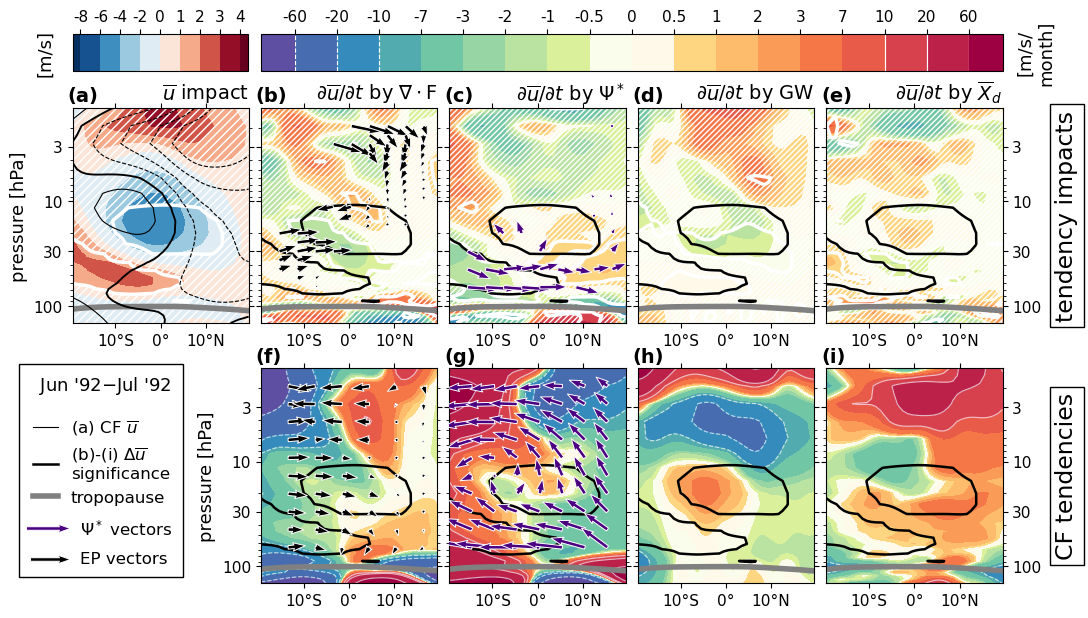

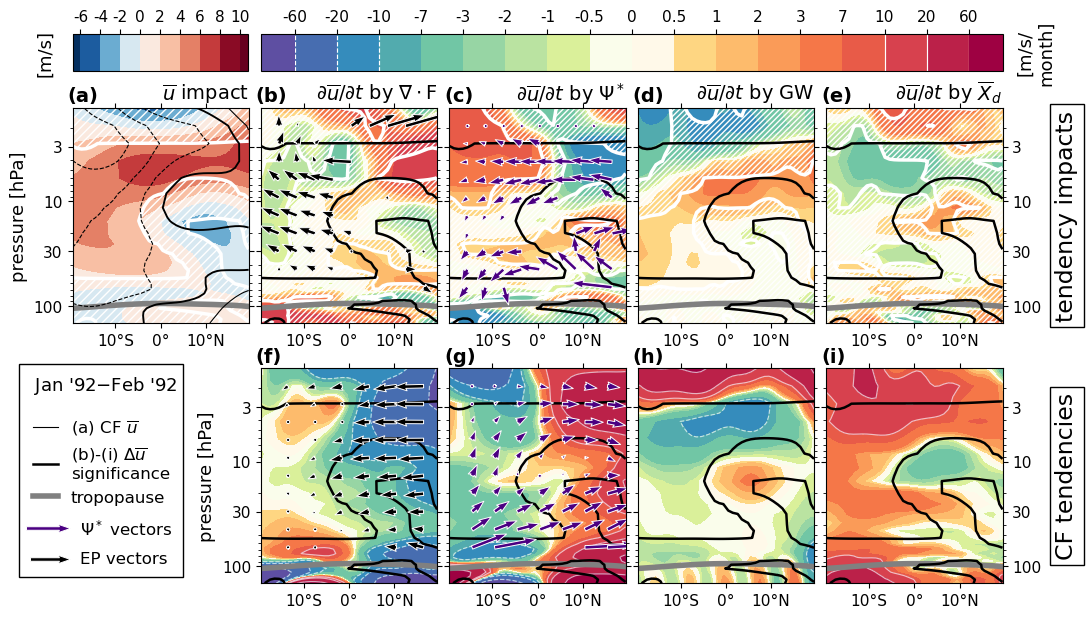

In [190]:
importlib.reload(putil)
importlib.reload(ces)

interpv = True
log_rvvec = True
iccf = True
iscf = False

if(0):

    # ========== NH MIDLATS FEB-MAR 1992 "winter response"
    latlim = [-1, 91]
    plim   = [0.5, 500]
    latticks = [0, 30, 60, 90]
    ulev = np.arange(-20, 70, 10)
    ilev = [-6, -4, -2, 0, 2, 4, 6, 8]
    #tendlev = [-40, -30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 30, 40, 50]
    tendlev = [-60, -30,  -10, -7, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7, 10, 30, 60]
    tendlev_cf_emph = [-10, 10]
    tendlev_cf_emph = np.array(tendlev)[np.abs(np.array(tendlev))>=10]
    tlim   = [date(1992, 2, 1), date(1992, 3, 1)]

    log_rvvec = True
    if(log_rvvec): rvvs = 15
    else: rvvs = 1e10
    log_epvec = True
    if(log_epvec): epvs, epvs_cf = 13, 13
    else: epvs, epvs_cf = 2e14, 2e14*10

    make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=epvs, epdsp=2, epdslat=8,
                                                       epvscale_cf=epvs_cf, epdsp_cf=5, epdslat_cf=8,
                                                       rvvscale=rvvs, rvdsp=2, rvdslat=8,
                                                       rvvscale_cf=rvvs, rvdsp_cf=5, rvdslat_cf=8,
                                                       tendlev_cf_emph=tendlev_cf_emph,
                   log_epfd_vectors=log_epvec, log_resvel_vectors=log_rvvec,
                   interp_vectors=interpv, 
                   lat_ticks=latticks, impact_contours_on_cf=iccf, 
                   impact_sig_on_cf=iscf, vector_tropp_buff=60)
    plt.savefig('figs/NH_latpBudget_FM1992.pdf', dpi=250, bbox_inches='tight')


    # ========== NH MIDLATS JULY-AUG 1991 "summer response"
    latlim = [-1, 91]
    plim   = [0.3, 500]
    latticks = [0, 30, 60, 90]
    ulev = -(np.arange(-20, 70, 10)[::-1])
    ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    #tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
    tendlev = [-60, -20, -10, -7, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7, 10, 20, 60]
    tendlev_cf_emph = [-10, 10]
    tendlev_cf_emph = np.array(tendlev)[np.abs(np.array(tendlev))>=10]
    tlim   = [date(1991, 7, 1), date(1991, 8, 1)]

    log_rvvec = True
    if(log_rvvec): rvvs = 12
    else: rvvs = 1e10
    log_epvec = False
    if(log_epvec): epvs, epvs_cf = 13, 13
    else: epvs, epvs_cf = 2e13, 2e13*10

    make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=epvs, epdsp=2, epdslat=6,
                                                       epvscale_cf=epvs_cf, epdsp_cf=5, epdslat_cf=8,
                                                       rvvscale=rvvs, rvdsp=3, rvdslat=7,
                                                       rvvscale_cf=rvvs+2, rvdsp_cf=5, rvdslat_cf=8,
                                                       tendlev_cf_emph=tendlev_cf_emph,
                log_epfd_vectors=log_epvec, log_resvel_vectors=log_rvvec,
                interp_vectors=interpv, lat_ticks=latticks, 
                impact_contours_on_cf=iccf, impact_sig_on_cf=iscf, vector_tropp_buff=60)
    plt.savefig('figs/NH_latpBudget_JA1991.pdf', dpi=250, bbox_inches='tight')

    # ========== NH MIDLATS JUL-AUG 1992 "summer response"
    latlim = [-1, 91]
    plim   = [0.3, 500]
    latticks = [0, 30, 60, 90]
    ulev = -(np.arange(-20, 70, 10)[::-1])
    ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    #tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
    tendlev = [-60, -20, -10, -7, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7, 10, 20, 60]
    tendlev_cf_emph = [-10, 10]
    tendlev_cf_emph = np.array(tendlev)[np.abs(np.array(tendlev))>=10]
    tlim   = [date(1992, 7, 1), date(1992, 8, 1)]

    log_rvvec = True
    if(log_rvvec): rvvs = 12
    else: rvvs = 1e10
    log_epvec = False
    if(log_epvec): epvs, epvs_cf = 13, 13
    else: epvs, epvs_cf = 3e13, 2e13*10

    make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=epvs, epdsp=4, epdslat=8,
                                                       epvscale_cf=epvs_cf, epdsp_cf=5, epdslat_cf=8,
                                                       rvvscale=rvvs, rvdsp=4, rvdslat=10,
                                                       rvvscale_cf=rvvs+2, rvdsp_cf=5, rvdslat_cf=8,
                                                       tendlev_cf_emph=tendlev_cf_emph,
                   log_epfd_vectors=log_epvec, log_resvel_vectors=log_rvvec,
                   interp_vectors=interpv, lat_ticks=latticks, 
                   impact_contours_on_cf=iccf, impact_sig_on_cf=iscf, vector_tropp_buff=60)
    plt.savefig('figs/NH_latpBudget_JA1992.pdf', dpi=250, bbox_inches='tight')

    
# ========== TROPICS JUNE-JULY 1992 "negative qbo response"
#latlim = [-30, 30]
latlim = [-20, 20]
plim   = [1, 150]
latticks = [-10, 0, 10]
ulev = np.arange(-60, 20, 10)
ilev = [-8, -6, -4, -2, 0, 1, 2, 3, 4]
#tendlev = [-8, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 8]
tendlev = [-60, -20, -10, -7, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7, 10, 20, 60]
tendlev_cf_emph = [-10, 10]
tendlev_cf_emph = np.array(tendlev)[np.abs(np.array(tendlev))>=10]
tlim   = [date(1992, 6, 1), date(1992, 7, 1)]

log_rvvec = True
if(log_rvvec): rvvs = 9
else: rvvs = 1e10
log_epvec = True
if(log_epvec): epvs, epvs_cf = 4, 6
else: epvs, epvs_cf = 8e13, 8e14

make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=epvs, epdsp=1, epdslat=4,
                                                   epvscale_cf=epvs_cf, epdsp_cf=2, epdslat_cf=6,
                                                   rvvscale=rvvs,   rvdsp=2, rvdslat=4, 
                                                   rvvscale_cf=rvvs+2, rvdsp_cf=2, rvdslat_cf=5,
                                                   tendlev_cf_emph=tendlev_cf_emph,
                      log_epfd_vectors=log_epvec, log_resvel_vectors=log_rvvec,
                      interp_vectors=interpv, lat_ticks=latticks, 
                      impact_contours_on_cf=iccf, impact_sig_on_cf=iscf, vector_tropp_buff=30)
plt.savefig('figs/tropics_latpBudget_JJ1992.pdf', dpi=250, bbox_inches='tight')


    
# ========== TROPICS JAN-FEB 1992 "positive qbo response"
#latlim = [-30, 30]
latlim = [-20, 20]
plim   = [1, 150]
latticks = [-10, 0, 10]
ulev = np.arange(-60, 20, 10)
ilev = [-6, -4, -2, 0, 2, 4, 6, 8, 10]
#tendlev = [-10, -8, -5, -2, -1, 0, 1, 2, 5, 8, 10]
tendlev = [-60, -20, -10, -7, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7, 10, 20, 60]
tendlev_cf_emph = [-10, 10]
tendlev_cf_emph = np.array(tendlev)[np.abs(np.array(tendlev))>=10]
tlim   = [date(1992, 1, 1), date(1992, 2, 1)]

log_rvvec = True
if(log_rvvec): rvvs = 6
else: rvvs = 1e10
log_epvec = True
if(log_epvec): epvs, epvs_cf = 3, 5
else: epvs, epvs_cf = 8e13, 2e15

make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=epvs, epdsp=2, epdslat=4, 
                                                   epvscale_cf=epvs_cf, epdsp_cf=2, epdslat_cf=6,
                                                   rvvscale=rvvs,   rvdsp=2, rvdslat=4,
                                                   rvvscale_cf=rvvs, rvdsp_cf=2, rvdslat_cf=5,
                                                   tendlev_cf_emph=tendlev_cf_emph,
                      log_epfd_vectors=log_epvec, log_resvel_vectors=log_rvvec,
                      interp_vectors=interpv, lat_ticks=latticks, 
                      impact_contours_on_cf=iccf, impact_sig_on_cf=iscf, vector_tropp_buff=30)
plt.savefig('figs/tropics_latpBudget_JF1992.pdf', dpi=250, bbox_inches='tight')


plt.show()